## Problem Statement: 
The goal of this casestudy is to categorise the countries using socio-economic and health factors into distinct groups based on their level of development and need for aid.

In [1]:
# Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.impute import SimpleImputer, KNNImputer

import re

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster import hierarchy  as hc
from sklearn.metrics import silhouette_score

from sklearn.pipeline import Pipeline
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Ingestion and Sanity Check

In [3]:
# Loading the data into a df
df = pd.read_csv('CountryAidAllocation.csv')

In [4]:
# Let's look at a few of the sample rows
df.sample(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
67,Hungary,6.0,81.80,7.33,76.5,22300,2.330,74.5,1.25,13100
12,Bangladesh,49.4,16.00,3.52,21.8,2440,7.140,70.4,2.33,758
136,Solomon Islands,28.1,49.30,8.55,81.2,1780,6.810,61.7,4.24,1290
95,Malaysia,7.9,86.90,4.39,71.0,21100,7.270,74.5,2.15,9070
42,Cyprus,3.6,50.20,5.97,57.5,33900,2.010,79.9,1.42,30800
13,Barbados,14.2,39.50,7.97,48.7,15300,0.321,76.7,1.78,16000
116,Pakistan,92.1,13.50,2.20,19.4,4280,10.900,65.3,3.85,1040
21,Botswana,52.5,43.60,8.30,51.3,13300,8.920,57.1,2.88,6350
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.200,55.0,5.20,399


Let's look at the different columns we have...

* country: Name of the country  
* child_mort: Death of children under 5 years of age per 1000 live births  
* exports: Exports of goods and services per capita. Given as %age of the GDP per capita  
* health: Total health spending per capita. Given as %age of GDP per capita  
* imports: Imports of goods and services per capita. Given as %age of the GDP per capita  
* income: Net income per person  
* inflation: The measurement of the annual growth rate of the Total GDP  
* life_expec: The average number of years a new born child would live if the current mortality patterns are to remain the same
* total_fer: The number of children that would be born to each woman if the current age-fertility rates remain the same  
* gdpp: The GDP per capita. Calculated as the Total GDP divided by the total population.  

In [5]:
# Let's look at the shape of the df
df.shape

(167, 10)

In [6]:
# Set pandas to display floats in plain number format upto 2 decimal points
pd.set_option('display.float_format', '{:.2f}'.format)

# Let's look at the 5 point summary of the numerical columns in the data
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,41.11,6.82,46.89,17144.69,7.78,70.56,2.95,12964.16
std,40.33,27.41,2.75,24.21,19278.07,10.57,8.89,1.51,18328.70
min,2.60,0.11,1.81,0.07,609.00,-4.21,32.10,1.15,231.00
25%,8.25,23.80,4.92,30.20,3355.00,1.81,65.30,1.79,1330.00
50%,19.30,35.00,6.32,43.30,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,51.35,8.60,58.75,22800.00,10.75,76.80,3.88,14050.00
max,208.00,200.00,17.90,174.00,125000.00,104.00,82.80,7.49,105000.00


## Data Preprocessing

### A) Duplicate Values Treatment

In [7]:
duplicateCount = df['country'].duplicated().sum()
print(f"The number of duplicate values in the 'Country' column is {duplicateCount}") 

The number of duplicate values in the 'Country' column is 0


### B) Null Values Treatment

In [8]:
df.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Looks like we don't have Null values in any of our columns

### C) Outlier Treatment

**Let's see if there are any outliers in the 'Child Mortality' column**

In [9]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['child_mort'].min()
Percentile25 = df['child_mort'].quantile(0.25)
Percentile75 = df['child_mort'].quantile(0.75)
maxVal = df['child_mort'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
CM_LB = Percentile25 - 1.5*IQR
CM_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {CM_LB}')
print(f'The theoretical upper cut off comes out to be {CM_UB}')
print("")

rightTailedOutliers = df[df['child_mort'] > CM_UB]['child_mort'].count()
leftTailedOutliers = df[df['child_mort'] < CM_LB]['child_mort'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is 2.6
The 25th percentile is 8.25
The 75th percentile is 62.1
The maximum value in the column is 208.0

The theoretical lower cut off comes out to be -72.525
The theoretical upper cut off comes out to be 142.875

The number of right-tailed outliers is 4
The number of left-tailed outliers is 0


*As we can see that the child mortality rate in some countries is as high as 208 per 1000 children.*  
*These values can very well be realistic for some of the third world countries out there. Hence, we are not going to substitute these outliers by any other value.*

**Let's see if there are any outliers in the 'Exports' column**

In [10]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['exports'].min()
Percentile25 = df['exports'].quantile(0.25)
Percentile75 = df['exports'].quantile(0.75)
maxVal = df['exports'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
Exports_LB = Percentile25 - 1.5*IQR
Exports_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {Exports_LB}')
print(f'The theoretical upper cut off comes out to be {Exports_UB}')
print("")

rightTailedOutliers = df[df['exports'] > Exports_UB]['exports'].count()
leftTailedOutliers = df[df['exports'] < Exports_LB]['exports'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is 0.109
The 25th percentile is 23.8
The 75th percentile is 51.349999999999994
The maximum value in the column is 200.0

The theoretical lower cut off comes out to be -17.524999999999988
The theoretical upper cut off comes out to be 92.67499999999998

The number of right-tailed outliers is 5
The number of left-tailed outliers is 0


*As we can see that the exports in some countries are as high as 200 % when expressed as a percentage of GDP.*  
*For small, trade-heavy and open economies, this can very well be the case. Hence, we'll not treat these outliers.*

**Let's see if there are any outliers in the 'Imports' column**

In [11]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['imports'].min()
Percentile25 = df['imports'].quantile(0.25)
Percentile75 = df['imports'].quantile(0.75)
maxVal = df['imports'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
Imports_LB = Percentile25 - 1.5*IQR
Imports_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {Imports_LB}')
print(f'The theoretical upper cut off comes out to be {Imports_UB}')
print("")

rightTailedOutliers = df[df['imports'] > Imports_UB]['imports'].count()
leftTailedOutliers = df[df['imports'] < Imports_LB]['imports'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is 0.0659
The 25th percentile is 30.2
The 75th percentile is 58.75
The maximum value in the column is 174.0

The theoretical lower cut off comes out to be -12.625000000000004
The theoretical upper cut off comes out to be 101.575

The number of right-tailed outliers is 4
The number of left-tailed outliers is 0


*As we can see that the imports in some countries are as high as 174% when expressed as a percentage of GDP.*  
*For small, trade-heavy and open economies, this can very well be the case. Hence, we'll not treat these outliers.*

**Let's see if there are any outliers in the 'Health' column**

In [12]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['health'].min()
Percentile25 = df['health'].quantile(0.25)
Percentile75 = df['health'].quantile(0.75)
maxVal = df['health'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
Health_LB = Percentile25 - 1.5*IQR
Health_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {Health_LB}')
print(f'The theoretical upper cut off comes out to be {Health_UB}')
print("")

rightTailedOutliers = df[df['health'] > Health_UB]['health'].count()
leftTailedOutliers = df[df['health'] < Health_LB]['health'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is 1.81
The 25th percentile is 4.92
The 75th percentile is 8.600000000000001
The maximum value in the column is 17.9

The theoretical lower cut off comes out to be -0.6000000000000023
The theoretical upper cut off comes out to be 14.120000000000005

The number of right-tailed outliers is 2
The number of left-tailed outliers is 0


*For half of the countries, spending on Healthcare as a percentage of the GDP is between 4.92% to 8.6% with a few countries spending as much as 17.9%.*  
*This values are very much realistic and therefore we wouldn't treat them*

**Let's see if there are any outliers in the 'Income' column**

In [13]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['income'].min()
Percentile25 = df['income'].quantile(0.25)
Percentile75 = df['income'].quantile(0.75)
maxVal = df['income'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
Income_LB = Percentile25 - 1.5*IQR
Income_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {Income_LB}')
print(f'The theoretical upper cut off comes out to be {Income_UB}')
print("")

rightTailedOutliers = df[df['income'] > Income_UB]['income'].count()
leftTailedOutliers = df[df['income'] < Income_LB]['income'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is 609
The 25th percentile is 3355.0
The 75th percentile is 22800.0
The maximum value in the column is 125000

The theoretical lower cut off comes out to be -25812.5
The theoretical upper cut off comes out to be 51967.5

The number of right-tailed outliers is 8
The number of left-tailed outliers is 0


*As we can see that for some of the countries out there, the per capita income is as high as $125,000 a year.*  
*Luxembourg is one such country with such high per capita income suggesting that these values are realistic and therefore we wouldn't treat them.*

**Let's see if there are any outliers in the 'Inflation' column**

In [14]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['inflation'].min()
Percentile25 = df['inflation'].quantile(0.25)
Percentile75 = df['inflation'].quantile(0.75)
maxVal = df['inflation'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
Inflation_LB = Percentile25 - 1.5*IQR
Inflation_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {Inflation_LB}')
print(f'The theoretical upper cut off comes out to be {Inflation_UB}')
print("")

rightTailedOutliers = df[df['inflation'] > Inflation_UB]['inflation'].count()
leftTailedOutliers = df[df['inflation'] < Inflation_LB]['inflation'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is -4.21
The 25th percentile is 1.81
The 75th percentile is 10.75
The maximum value in the column is 104.0

The theoretical lower cut off comes out to be -11.6
The theoretical upper cut off comes out to be 24.16

The number of right-tailed outliers is 5
The number of left-tailed outliers is 0


*As we can see that there are some countries with inflation greater than 100%.*  
*Such cases of hyperinflation can exist in the real world owing to factors like excessive money printing. Therefore, we would treat these values as realistic and not treat them.*

**Let's see if there are any outliers in the 'Life Expectancy' column**

In [15]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['life_expec'].min()
Percentile25 = df['life_expec'].quantile(0.25)
Percentile75 = df['life_expec'].quantile(0.75)
maxVal = df['life_expec'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
LifeExp_LB = Percentile25 - 1.5*IQR
LifeExp_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {LifeExp_LB}')
print(f'The theoretical upper cut off comes out to be {LifeExp_UB}')
print("")

rightTailedOutliers = df[df['life_expec'] > LifeExp_UB]['life_expec'].count()
leftTailedOutliers = df[df['life_expec'] < LifeExp_LB]['life_expec'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is 32.1
The 25th percentile is 65.3
The 75th percentile is 76.8
The maximum value in the column is 82.8

The theoretical lower cut off comes out to be 48.05
The theoretical upper cut off comes out to be 94.05

The number of right-tailed outliers is 0
The number of left-tailed outliers is 3


*As we can see that the life expectancy for some of the countries out there is as low as 32 years.*  
*These values can very well be true for some of the third world countries out there. Hence, we are not going to treat them.*

**Let's see if there are any outliers in the 'Fertility' column**

In [16]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['total_fer'].min()
Percentile25 = df['total_fer'].quantile(0.25)
Percentile75 = df['total_fer'].quantile(0.75)
maxVal = df['total_fer'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
TotalFert_LB = Percentile25 - 1.5*IQR
TotalFert_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {TotalFert_LB}')
print(f'The theoretical upper cut off comes out to be {TotalFert_UB}')
print("")

rightTailedOutliers = df[df['total_fer'] > TotalFert_UB]['total_fer'].count()
leftTailedOutliers = df[df['total_fer'] < TotalFert_LB]['total_fer'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is 1.15
The 25th percentile is 1.795
The 75th percentile is 3.88
The maximum value in the column is 7.49

The theoretical lower cut off comes out to be -1.3325
The theoretical upper cut off comes out to be 7.0075

The number of right-tailed outliers is 1
The number of left-tailed outliers is 0


*For a woman to bear 7-8 children in a lifetime doesn't sound too unrealistic. and hence, we wouldn't treat these as outliers*

**Let's see if there are any outliers in the 'GDP Per Capita' column**

In [17]:
# Let's look at the min, max, 25th and 75th percentiles.

minVal = df['gdpp'].min()
Percentile25 = df['gdpp'].quantile(0.25)
Percentile75 = df['gdpp'].quantile(0.75)
maxVal = df['gdpp'].max()

print(f'The minimum value in the column is {minVal}')
print(f'The 25th percentile is {Percentile25}')
print(f'The 75th percentile is {Percentile75}')
print(f'The maximum value in the column is {maxVal}')
print('')

# Inter-quartile range
IQR = Percentile75 - Percentile25

# Lower and upper bounds
# data points lying beyond these bounds will be considered as outliers
GDPPerCap_LB = Percentile25 - 1.5*IQR
GDPPerCap_UB = Percentile75 + 1.5*IQR

print(f'The theoretical lower cut off comes out to be {GDPPerCap_LB}')
print(f'The theoretical upper cut off comes out to be {GDPPerCap_UB}')
print("")

rightTailedOutliers = df[df['gdpp'] > GDPPerCap_UB]['gdpp'].count()
leftTailedOutliers = df[df['gdpp'] < GDPPerCap_LB]['gdpp'].count()

print(f"The number of right-tailed outliers is {rightTailedOutliers}")
print(f"The number of left-tailed outliers is {leftTailedOutliers}")

The minimum value in the column is 231
The 25th percentile is 1330.0
The 75th percentile is 14050.0
The maximum value in the column is 105000

The theoretical lower cut off comes out to be -17750.0
The theoretical upper cut off comes out to be 33130.0

The number of right-tailed outliers is 25
The number of left-tailed outliers is 0


*As we can see that for some of the countries out there, the GDP per capita is as high as $105,000 a year.*  
*Luxembourg is one such country with such high GDP per capita figures suggesting that these values are realistic and therefore we wouldn't treat them.*

## Data Visualization

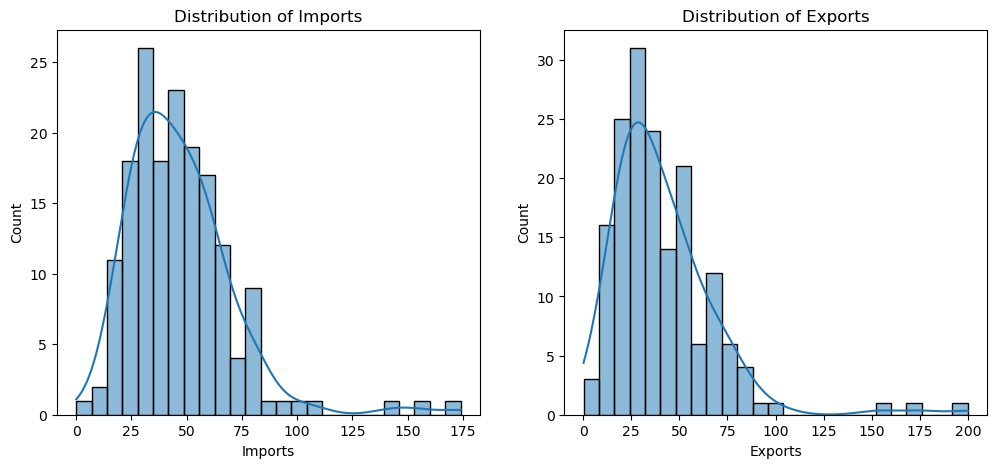

In [18]:
fig, axes = plt.subplots(1,2, figsize = (12,5))

# let's look at the distribution of the Imports column
axes[0].set_title('Distribution of Imports')
axes[0].set_xlabel('Imports')
sns.histplot(ax = axes[0], x= df['imports'], bins = 25, kde = True)

# let's look at the distribution of the Exports column
axes[1].set_title('Distribution of Exports')
axes[1].set_xlabel('Exports')
sns.histplot(ax = axes[1], x= df['exports'], bins = 25, kde = True)

plt.show()

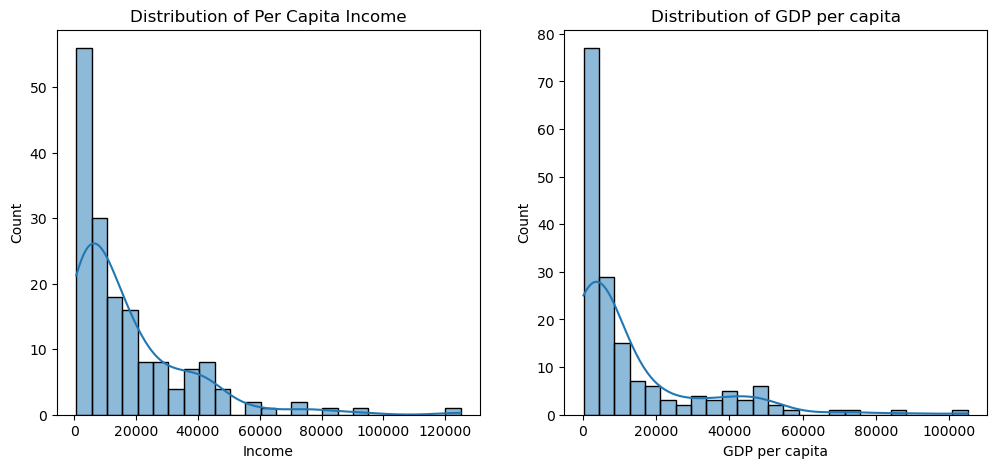

In [19]:
fig, axes = plt.subplots(1,2, figsize = (12,5))

# let's look at the distribution of the Imports column
axes[0].set_title('Distribution of Per Capita Income')
axes[0].set_xlabel('Income')
sns.histplot(ax = axes[0], x= df['income'], bins = 25, kde = True)

# let's look at the distribution of the Exports column
axes[1].set_title('Distribution of GDP per capita')
axes[1].set_xlabel('GDP per capita')
sns.histplot(ax = axes[1], x= df['gdpp'], bins = 25, kde = True)

plt.show()

*As we can see from the visualizations above, that majority of the countries have a per capita income of under 20,000 US dollars, with some exceptions where the per capita income is close to 120,000 US dollars a year.*  
*GDP per capita suggests the same pattern, with most of the data points lying below 20,000 US dollars, with a few exceptions where the GDP per capita is over 100,000 US dollars.*

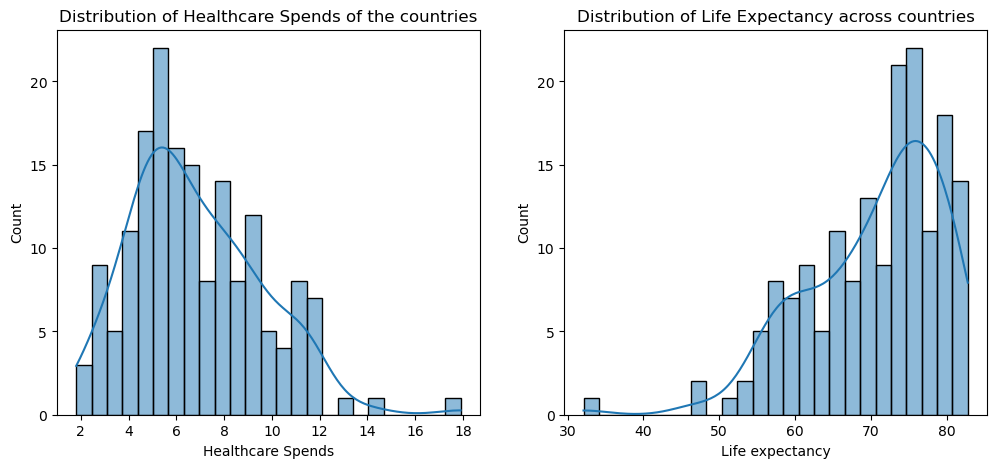

In [20]:
fig, axes = plt.subplots(1,2, figsize = (12,5))

# let's look at the distribution of the Imports column
axes[0].set_title('Distribution of Healthcare Spends of the countries')
axes[0].set_xlabel('Healthcare Spends')
sns.histplot(ax = axes[0], x= df['health'], bins = 25, kde = True)

# let's look at the distribution of the Exports column
axes[1].set_title('Distribution of Life Expectancy across countries')
axes[1].set_xlabel('Life expectancy')
sns.histplot(ax = axes[1], x= df['life_expec'], bins = 25, kde = True)

plt.show()

*As it's apparent from the visualizations above, for most of the countries the healthcare spend is between 4 to 8% of their GDP, with a few exceptions of some first world countries spending as high as 18% of their GDP on healthcare.*  
*As for the life expectancy, we see a few outliers on the left side of the distribution suggesting life expectancy across a few countries to be as low as 30 years.*

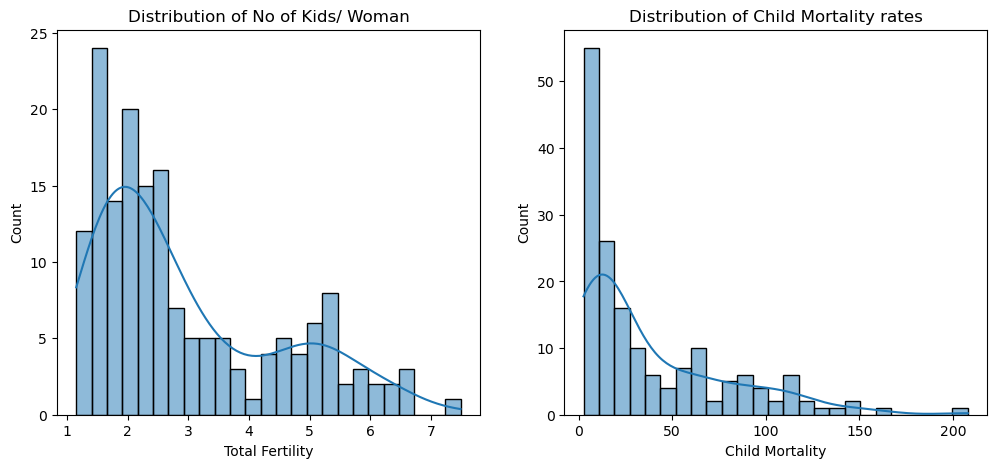

In [21]:
fig, axes = plt.subplots(1,2, figsize = (12,5))

# let's look at the distribution of the Imports column
axes[0].set_title('Distribution of No of Kids/ Woman')
axes[0].set_xlabel('Total Fertility')
sns.histplot(ax = axes[0], x= df['total_fer'], bins = 25, kde = True)

# let's look at the distribution of the Exports column
axes[1].set_title('Distribution of Child Mortality rates')
axes[1].set_xlabel('Child Mortality')
sns.histplot(ax = axes[1], x= df['child_mort'], bins = 25, kde = True)

plt.show()

*As we can see from the graphs above, that on an average, a woman is going to have two to three children, with the outliers indicating instances of women having up to seven children.*  
*The child mortality rates per 1,000 also are below 40 for majority of the countries, with some outliers indicating child mortality rates as high as 200.*

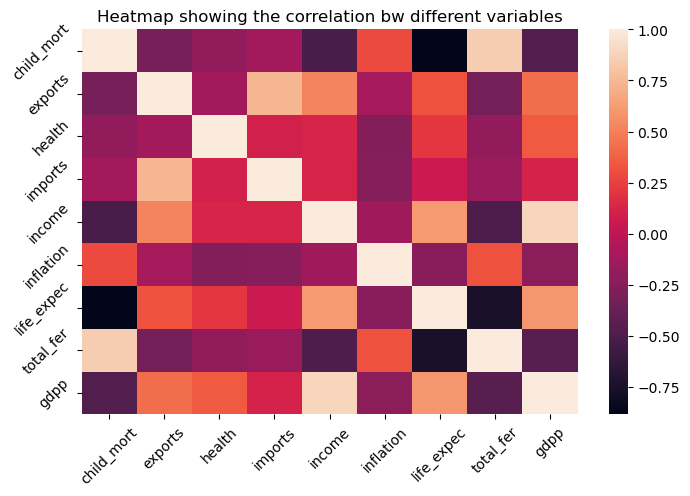

In [22]:
# Heatmap showing the correlation bw different variables
plt.figure(figsize = (8,5))
sns.heatmap(df.drop(columns=['country']).corr())
plt.title('Heatmap showing the correlation bw different variables')
plt.xticks(rotation =45)
plt.yticks(rotation =45)
plt.show()

**Observatons:**  
*As we can see from the heatmap above, features like total fertility and child mortality have a higher correlation, suggesting that a woman is inclined to have more kids, if she knows that some of her kids may not survive.*  
*Another observation is that GDP per capita and per capita income of the individuals have a higher correlation.*  
*However, features like life expectancy and child mortality have a quite high negative correlation, suggesting that for these poor countries, the child mortality rates are going to be higher and the life expectancy is going to be lower in general.*

## Clustering

**Scaling**

It's important to scale the Numerical features to bring them on the same scale as it might affect the working of the clustering algos coz of them being distance-based algorithms.  
We'll use MinMaxScaler, transforming the feature values to fall within the bounded intervals (min and max).

In [23]:
scaler = MinMaxScaler()
NumCols = df.drop(columns=['country']).copy()
df_scaled = scaler.fit_transform(NumCols)

### A) K means Clustering

**Elbow method**

Let's calculate the Within Cluster Sum of Squared Errors (WCSS) for different values of K  
And then choose the value (of k) for which WCSS first starts to flaten out.

In [24]:
# Inertia (Within Cluster Sum of Squares)
kmeans_per_k = [KMeans(n_clusters=k, init='k-means++', random_state=17).fit(df_scaled)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]

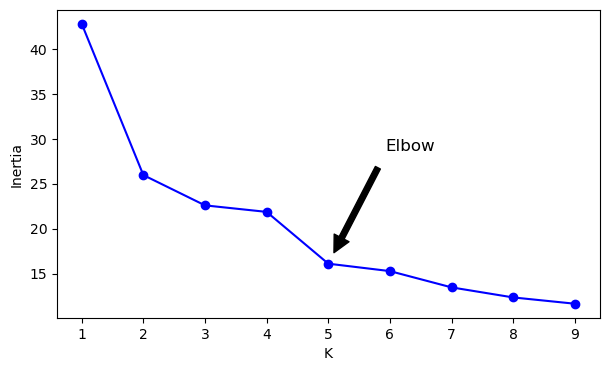

In [25]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel('K')
plt.ylabel('Inertia')
plt.annotate('Elbow',
             xy=(5, inertias[4]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

*As we can see in the graph above, that beyond five clusters, the inertia really starts flattening out. So, we can assume 5 to be the optimal number of clusters that are there in the data.*

In [26]:
# Let's build the model again with k = 5

kmeans= KMeans(n_clusters=5, random_state=19)
kmeans.fit(df_scaled)

# Let's label the datapoints in the original df on the basis of the cluster assigned to them
df_KMeans = df.copy()
df_KMeans['cluster'] = kmeans.predict(df_scaled)

*Let's look at some of the sample countries after labelling them acc to the category they fall into.*

In [27]:
df_KMeans.sample(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
36,Comoros,88.20,16.50,4.51,51.70,1410,3.87,65.90,4.75,769,1
35,Colombia,18.60,15.90,7.59,17.80,10900,3.86,76.40,2.01,6250,2
47,Egypt,29.10,21.30,4.66,26.60,9860,10.10,70.50,3.19,2600,0
153,Turkey,19.10,20.40,6.74,25.50,18000,7.01,78.20,2.15,10700,2
162,Vanuatu,29.20,46.60,5.25,52.70,2950,2.62,63.00,3.50,2970,0


*Let's look at the averages of the features when the countries are grouped into their respective categories.*

In [28]:
df_KMeans.groupby('cluster').mean(numeric_only=True)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,32.67,37.07,5.20,42.33,10408.24,10.15,69.69,2.80,4831.02
1,98.23,27.26,6.34,42.62,2913.49,12.29,58.97,5.23,1393.71
2,11.99,46.69,7.63,53.61,17032.39,4.21,75.53,1.80,10599.78
3,5.15,45.42,9.30,38.00,47588.46,2.98,80.46,1.86,46200.00
4,4.13,176.00,6.79,156.67,64033.33,2.47,81.43,1.38,57566.67


*As we can see that the clustering seems pretty logical. For instance, countries grouped under Category 1 show relatively high child mortality rates. This is consistent with the observation that women in these nations tend to have more children, partly due to the awareness that some may not survive. Secondly, the per capita income (<3000 USD) and GDP per capita (<1400 USD) for these countries is on the lower side as well.*

*Now when you contrast it with the countries from Category 4, you find that these countries have a significantly lower child mortality rate and the life expectancy in general is also upwards of 80. Plus, the per capita income and GDP per capita is also among the highest.* 

**Silhouette score for K Means with 5 clusters**

In [29]:
silhouette_score(df_scaled, kmeans.labels_)

0.24057652926925185

**Insight:**  
*The silhouette score of just 0.24 suggests that while there is some structure, the clusters are not very distinct — points are relatively close to neighboring clusters, and boundaries are fuzzy.*

### B) Hierarchical Clustering

Agglomerative clustering is a bottom-up hierarchical method that starts with each data point as its own cluster and iteratively merges the closest pairs until all points belong to a single cluster or a stopping criterion is met.

In [30]:
# Linkage matrix
Z = hc.linkage(df_scaled, method = 'ward')

Text(0, 0.5, 'distance')

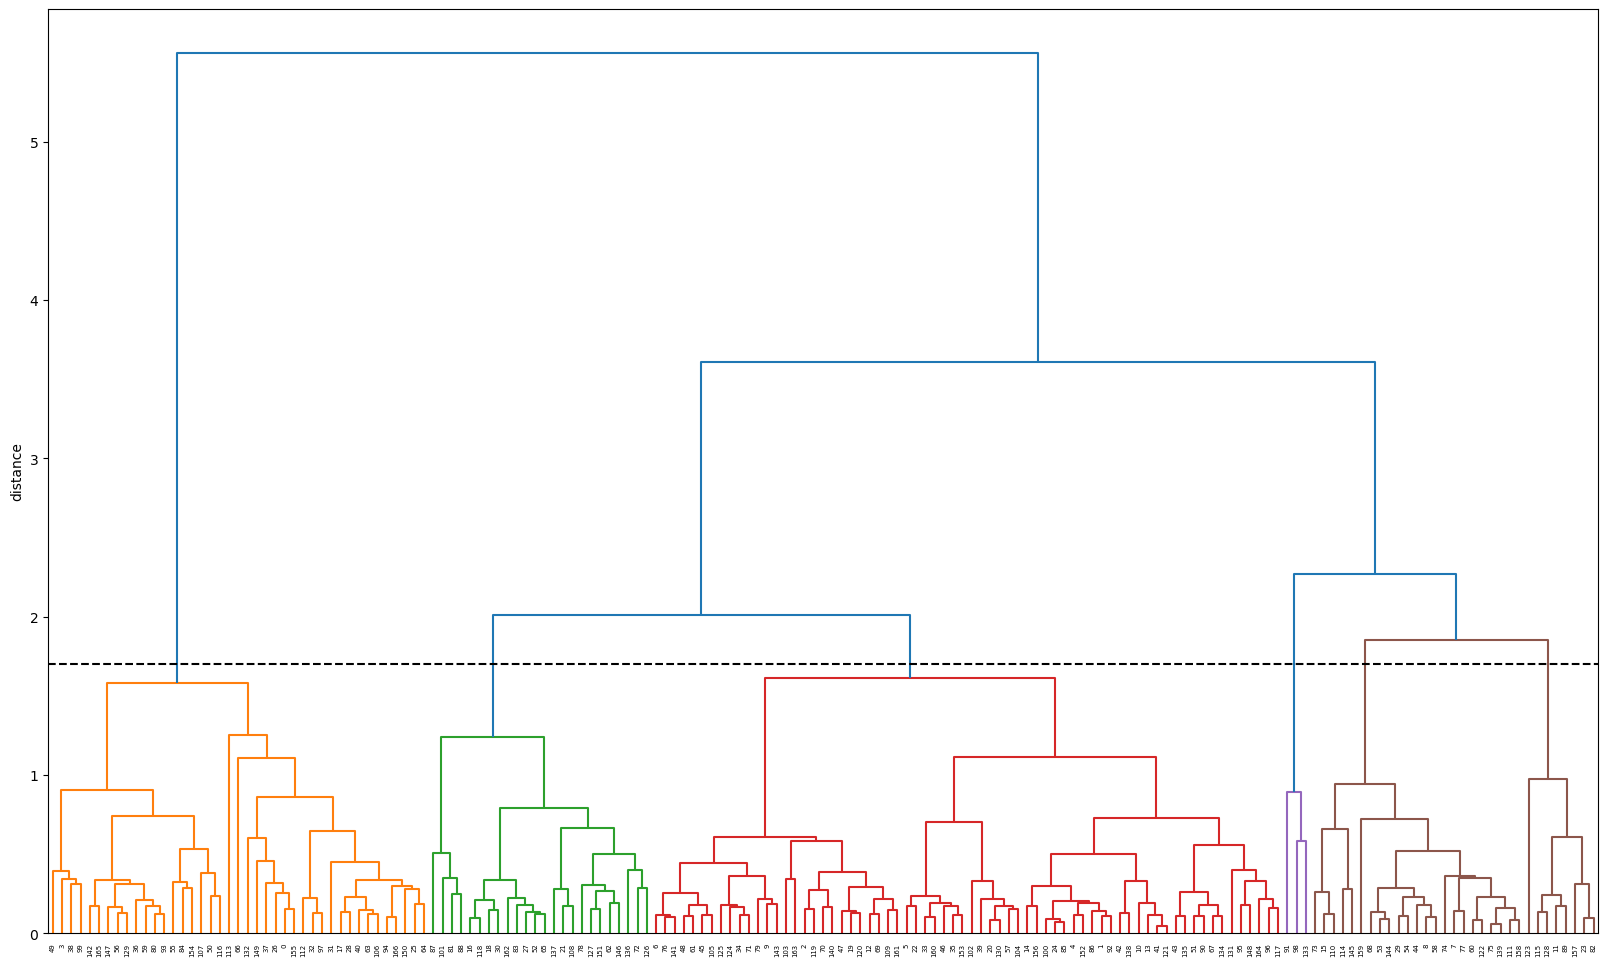

In [31]:
fig, ax = plt.subplots(figsize=(20, 12))

hc.dendrogram(Z, ax = ax, color_threshold=2)
plt.xticks(rotation = 90)
# Drawing a horizontal line at a distance of 1.7 
plt.axhline(y=1.7, color='k', linestyle='--')
ax.set_ylabel('distance')

*The dendogramic distance along the y-axis signifies as to at what level of similarity the clusters were merged.*  
*If we draw a horizontal line at a dendrogrammic distance of, say, 1.7, the number of vertical lines it intersects with, gives us the number of clusters, in this case, 6.*

**We are going to build several hierarchical clustering models, considering the number of clusters ranging from 2-10, and decide on the basis of the silhouette score.**

In [32]:
## Trying for values bw 2-10 for n_clusters and finding the corresponding silhoutte score

def hierarchical_clustering_silhouette(dataset, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(dataset)
    silhouette = silhouette_score(dataset, labels)
    return silhouette

In [33]:
for n_clusters in range(2,11):
  sil_avg = hierarchical_clustering_silhouette(df_scaled, n_clusters)
  print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {sil_avg}")

For n_clusters = 2, the average silhouette_score is : 0.37713531131793254
For n_clusters = 3, the average silhouette_score is : 0.31627506051649634
For n_clusters = 4, the average silhouette_score is : 0.31677468820192906
For n_clusters = 5, the average silhouette_score is : 0.22858307892680912
For n_clusters = 6, the average silhouette_score is : 0.25517718339753337
For n_clusters = 7, the average silhouette_score is : 0.22088275007790625
For n_clusters = 8, the average silhouette_score is : 0.20708706242955838
For n_clusters = 9, the average silhouette_score is : 0.21171683610915407
For n_clusters = 10, the average silhouette_score is : 0.2168813110359832


### C) DBSCAN

DBSCAN groups together points that are densely packed (within a pre-defined radius and min number of neighbors) while marking sparse, isolated points as noise.

In [34]:
df_DBSCAN = df.copy()

In [35]:
# Define ranges for eps and min_samples
epsilons = [0.01, 0.05, 0.1, 1.0, 5.0, 10.0]       
min_neighbours = [5, 10, 15, 20]         

# Loop through all combinations
for n_neighbours in min_neighbours:
    for e in epsilons:
        # Initialize DBSCAN with current epsilon and min_samples
        dbsc = DBSCAN(eps=e, min_samples=n_neighbours)
        
        # Fit the model to the scaled dataset
        dbsc.fit(df_scaled)
        
        # Save the cluster labels (-1 means noise)
        labels = dbsc.labels_

        # Count clusters, excluding noise points (-1)
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Only compute silhouette score if there are at least 2 clusters
        if num_clusters > 1:
            score = silhouette_score(df_scaled, labels)
            print(f"eps={e:.2f}, neighbours = {n_neighbours}, clusters={num_clusters}, silhouette={score:.3f}")
        else:
            print(f"eps={e:.2f}, neighbours = {n_neighbours}, clusters={num_clusters}, silhouette=N/A (invalid)")

eps=0.01, neighbours = 5, clusters=0, silhouette=N/A (invalid)
eps=0.05, neighbours = 5, clusters=0, silhouette=N/A (invalid)
eps=0.10, neighbours = 5, clusters=0, silhouette=N/A (invalid)
eps=1.00, neighbours = 5, clusters=1, silhouette=N/A (invalid)
eps=5.00, neighbours = 5, clusters=1, silhouette=N/A (invalid)
eps=10.00, neighbours = 5, clusters=1, silhouette=N/A (invalid)
eps=0.01, neighbours = 10, clusters=0, silhouette=N/A (invalid)
eps=0.05, neighbours = 10, clusters=0, silhouette=N/A (invalid)
eps=0.10, neighbours = 10, clusters=0, silhouette=N/A (invalid)
eps=1.00, neighbours = 10, clusters=1, silhouette=N/A (invalid)
eps=5.00, neighbours = 10, clusters=1, silhouette=N/A (invalid)
eps=10.00, neighbours = 10, clusters=1, silhouette=N/A (invalid)
eps=0.01, neighbours = 15, clusters=0, silhouette=N/A (invalid)
eps=0.05, neighbours = 15, clusters=0, silhouette=N/A (invalid)
eps=0.10, neighbours = 15, clusters=0, silhouette=N/A (invalid)
eps=1.00, neighbours = 15, clusters=1, silho

**Insight:**

*As we can see that DBSCAN is giving abysmal results for the hyperparameter combinations that we've tried*  
*It could be due to our dataset being more continuous/gradient-like rather than having clear dense blobs, causing DBSCAN to struggle.*  
*As a result, the algorithm is treating most of the points as **Noise** or putting everything in one big cluster, explaining why silhouette is **Invalid** in most runs.*

### Model Finalization

*From all the models we've tried, we can conclude that DBSCAN is not an appropriate choice of model at all.*  
*K-means and Agglomerative clustering are giving similar results.*  

*As for the Agglomerative clustering, it's is tricky in production because it doesn’t learn centroids like KMeans; it only clusters the training data it was fit on. This means new, unseen data can’t be directly assigned to clusters without rebuilding the entire hierarchy, which is computationally expensive and inconsistent.*  

*So, we'd finalize K Means algorith with n_clusters set to 5*

In [36]:
# While training the model, we'll wrap our preprocessing (scaling) inside a pipeline along with the clustering algo, then serialize the entire pipeline. 
# At inference time, when we call pipeline.predict(new_data), it'll automatically apply the scaler before clustering.

# Define pipeline
pipeline = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("KMeansCluster", KMeans(n_clusters=5, random_state=19))
])

# Fit pipeline on training data
pipeline.fit(NumCols)

,steps,"[('scaler', ...), ('KMeansCluster', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300


In [37]:
joblib.dump(pipeline, "C:/Users/theBlackMamba/Desktop/MLOps/Clustering/model/pipeline.pkl")

['C:/Users/theBlackMamba/Desktop/MLOps/Clustering/model/pipeline.pkl']